In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# Identifikujte aktivní a neaktivní stanice

In [147]:
# Dataset obsahuje 340986 řádků a 13 sloupců.
df = pd.read_csv("J:/edinburgh_bikes.csv")
df.head(5)

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
0,2018-09-15 08:52:05.960000+00:00,2018-09-15 09:11:48.464000+00:00,1182,247,Charlotte Square,North Corner of Charlotte Square,55.952335,-3.207101,259,St Andrew Square,North East corner,55.954728,-3.192653
1,2018-09-15 09:24:33.571000+00:00,2018-09-15 09:41:09.005000+00:00,995,259,St Andrew Square,North East corner,55.954749,-3.192774,262,Canonmills,near Tesco's,55.962804,-3.196284
2,2018-09-15 09:48:54.291000+00:00,2018-09-15 10:46:40.575000+00:00,3466,262,Canonmills,near Tesco's,55.962804,-3.196284,250,Victoria Quay,Entrance to Scottish Government Office,55.977638,-3.174116
3,2018-09-16 12:01:36.111000+00:00,2018-09-16 12:25:26.687000+00:00,1430,255,Kings Buildings 4,X-Y Cafe,55.922001,-3.176902,254,Kings Building 3,Kings Building House,55.923479,-3.175385
4,2018-09-16 12:03:43.982000+00:00,2018-09-16 12:11:16.570000+00:00,452,255,Kings Buildings 4,X-Y Cafe,55.922001,-3.176902,253,Kings Building 2,Sanderson Building,55.923202,-3.171646


In [148]:
# Zjistíme datum poslední výpůjčky. Poté rozhodneme, co je ještě aktivní stanice a co ne.
# Upravíme časový formát z '2018-09-15 08:52:05.960000+00:00' na '2018-09-15'.
df['started_at'] = df['started_at'].str.split(' ').str[0]
df['ended_at'] = df['ended_at'].str.split(' ').str[0]

# Vybereme pouze stanice, které byly aktivní (sloupec ended_at) alespoň k datu 2020-10-01 (1. října 2020). 
# Počet aktivních stanic se tak sníží na ze 199 na 110.
activeStationsList = []
df_temp = df[df["ended_at"] >= '2020-10-01']
activeStationsList = list(df_temp.end_station_id.unique())

# Vytvoříme dataframe pouze s aktivními stanicemi.
df_active_stations = df[df['start_station_id'].isin(activeStationsList)]
# Ukázka dataframu.
df_active_stations.head(5)

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
0,2018-09-15,2018-09-15,1182,247,Charlotte Square,North Corner of Charlotte Square,55.952335,-3.207101,259,St Andrew Square,North East corner,55.954728,-3.192653
1,2018-09-15,2018-09-15,995,259,St Andrew Square,North East corner,55.954749,-3.192774,262,Canonmills,near Tesco's,55.962804,-3.196284
2,2018-09-15,2018-09-15,3466,262,Canonmills,near Tesco's,55.962804,-3.196284,250,Victoria Quay,Entrance to Scottish Government Office,55.977638,-3.174116
5,2018-09-16,2018-09-16,228,253,Kings Building 2,Sanderson Building,55.923202,-3.171646,252,Kings Buildings 1,Grant Institute,55.924185,-3.173831
6,2018-09-16,2018-09-16,366,252,Kings Buildings 1,Grant Institute,55.924185,-3.173831,254,Kings Building 3,Kings Building House,55.923479,-3.175385


# Identifikujte nejfrekventovanější stanice

In [149]:
# Spočítáme kolikrát bylo v každé stanici kolo půjčeno a kolikrát vráceno.
station_frequency = (df_active_stations
                        .agg({'start_station_id': 'value_counts', 'end_station_id': 'value_counts'})
                        .dropna()
# Výsledné hodnoty poté sečteme.
                        .apply(lambda row: row['start_station_id'] + row['end_station_id'], axis=1)
                        .astype(int)
                        .sort_values())

In [150]:
# Numpy array převedeme do dataframe.
df_station_frequency = (station_frequency.to_frame()
                                            .reset_index()
                                            .rename(columns={'index': 'start_station_id', 0: 'frequency'}))

In [151]:
# Propojíme df_station_freqeuncy a df_active_stations.
df_station_frequency = (pd.merge(df_station_frequency, df_active_stations[['start_station_id','start_station_name']], 
                                 how='inner', on='start_station_id'))

In [152]:
# Vymažeme duplikátní hodnoty, stanice seřadíme od nejfrekventovanější po nejméně frekventovanou
df_station_frequency = (df_station_frequency.loc[pd.DataFrame(np.sort(df_station_frequency[['start_station_id']],1),
                                    index=df_station_frequency.index)
                                    .drop_duplicates(keep='first').index]
                                    .sort_values(by='frequency', ascending=False)
                                    .reset_index(drop=True))

In [153]:
# Top 5 nejrušnějších stanic.
df_station_frequency.head(5)

,start_station_id,frequency,start_station_name
0,265,22576,Meadows East
1,1728,18093,Portobello - Kings Road
2,250,17883,Victoria Quay
3,259,16186,St Andrew Square
4,248,15937,Bristo Square


In [202]:
# Top 5 nejméně využívaných stanic.
df_station_frequency.tail(5)

,start_station_id,frequency,start_station_name
105,1877,288,Port Edgar Marina
106,1860,280,Ingliston Park & Ride
107,1871,228,Scotstoun House
108,2265,104,Musselburgh Brunton Hall
109,1031,47,Eden Locke - Aparthotel (RESIDENTS ONLY)


# Identifikujte stanice, na kterých se kola hromadí a stanice, kde potenciálně chybí.

In [12]:
# Spočítáme kolikrát bylo v každé stanici kolo půjčeno a kolikrát vráceno.
station_return = (df_active_stations.agg({'start_station_id': 'value_counts', 'end_station_id': 'value_counts'})
                                       .dropna()
# Výsledné hodnoty poté od sebe odečteme.
                                       .apply(lambda row: row['end_station_id'] - row['start_station_id'], axis=1)
                                       .astype(int)
                                       .sort_values())

In [13]:
# Numpy array převedeme do dataframe
df_station_return = (station_return.to_frame()
                                      .reset_index()
                                      .rename(columns={'index': 'start_station_id', 0: 'return'}))

In [14]:
# Spojíme df_station_return a df_active_stations
df_station_return = (pd.merge(df_station_return, df_active_stations[['start_station_id','start_station_name',
                                                                    'start_station_latitude', 'start_station_longitude']], 
                              how='inner', on='start_station_id'))

In [200]:
# Vymažeme duplikátní hodnoty.
df_station_return = (df_station_return.loc[pd.DataFrame(
                                        np.sort(df_station_return[['start_station_id']],1), index=df_station_return.index)
                                        .drop_duplicates(keep='first').index]
                                        .reset_index(drop=True))

# Záporná hodnota ukazuje, že kola k vypůjčení mohou potencionálně scházet (start_station_id > end_station_id).
df_station_return.head(5)

,start_station_id,return,start_station_name,start_station_latitude,start_station_longitude
0,248,-6061,Bristo Square,55.946004,-3.188665
1,259,-4558,St Andrew Square,55.954749,-3.192774
2,247,-3372,Charlotte Square,55.952335,-3.207101
3,189,-2915,City Chambers,55.950109,-3.190258
4,265,-2854,Meadows East,55.939809,-3.182739


In [201]:
# Kladná hodnota u stanice znamená, že zákazníci do dané stanice spíše kola vrací než si je vypůjčují ...
# ... kola proto mohou potencionálně ve stanici přebývat.
df_station_return.tail(5)

,start_station_id,return,start_station_name,start_station_latitude,start_station_longitude
105,1818,829,Dynamic Earth,55.951089,-3.175725
106,250,1603,Victoria Quay,55.977638,-3.174116
107,1728,2021,Portobello - Kings Road,55.957915,-3.118332
108,358,2032,Leith Walk,55.965040,-3.176686
109,1824,2341,Duke Street,55.969012,-3.167395


# Spočítejte vzdálenosti mezi jednotlivými stanicemi

In [155]:
from itertools import combinations

In [156]:
# Spojíme df_station_geo a df_active_stations
df_station_geo = pd.DataFrame(activeStationsList).rename(columns={0: 'start_station_id'})
df_station_geo = pd.merge(df_station_geo, df_active_stations[['start_station_id', 'start_station_name', 'start_station_latitude', 'start_station_longitude']], how='inner', on='start_station_id')
df_station_geo.head(5)

,start_station_id,start_station_name,start_station_latitude,start_station_longitude
0,1102,Haymarket Station,55.945582,-3.218192
1,1102,Haymarket Station,55.945582,-3.218192
2,1102,Haymarket Station,55.945582,-3.218192
3,1102,Haymarket Station,55.945582,-3.218192
4,1102,Haymarket Station,55.945582,-3.218192


In [157]:
# Vymažeme duplikátní hodnoty.
df_station_geo = (df_station_geo.loc[pd.DataFrame(np.sort(df_station_geo[['start_station_id']],1),
                                        index=df_station_geo.index)
                                        .drop_duplicates(keep='first').index]
                 .rename(columns={'start_station_id': 'id', 'start_station_name': 'station', 
                                  'start_station_latitude': 'latitude', 'start_station_longitude': 'longitude'}))
df_station_geo.head(5)

,id,station,latitude,longitude
0,1102,Haymarket Station,55.945582,-3.218192
2241,1744,Morningside Road,55.927985,-3.209750
4793,1025,Dundee Terrace,55.939710,-3.220589
10170,262,Canonmills,55.962804,-3.196284
17759,1818,Dynamic Earth,55.951089,-3.175725


In [158]:
# Vytvoříme všechny možné kombinace stanic bez opakování.
df_station_pairs = pd.DataFrame(list(combinations(df_station_geo.station, 2)), columns=['start_station', 'end_station'])

In [159]:
# Spojíme df_station_pairs a df_station_geo
df_station_pairs = (df_station_pairs.join(df_station_geo.set_index('station').add_prefix('start_'), on='start_station')
                   .join(df_station_geo.set_index('station').add_prefix('end_'), on='end_station'))
df_station_pairs.head(5)

,start_station,end_station,start_id,start_latitude,start_longitude,end_id,end_latitude,end_longitude
0,Haymarket Station,Morningside Road,1102,55.945582,-3.218192,1744,55.927985,-3.209750
1,Haymarket Station,Dundee Terrace,1102,55.945582,-3.218192,1025,55.939710,-3.220589
2,Haymarket Station,Canonmills,1102,55.945582,-3.218192,262,55.962804,-3.196284
3,Haymarket Station,Dynamic Earth,1102,55.945582,-3.218192,1818,55.951089,-3.175725
4,Haymarket Station,Castle Terrace,1102,55.945582,-3.218192,296,55.946766,-3.202038


In [160]:
# Spočítáme rozdíly v zeměpisné šířce (latitude) a délce (longitude) pro každou z dvojic.
df_lat_distance = (df_station_pairs.apply(lambda row: row['start_latitude'] - row['end_latitude'], axis=1)
         .to_frame()
         .rename(columns={0: 'distance_latitude'}))

df_lon_distance = (df_station_pairs.apply(lambda row: row['start_longitude'] - row['end_longitude'], axis=1)
         .to_frame()
         .rename(columns={0: 'distance_longitude'}))

# Výsledné hodnoty připojíme k df_stations_pairs.
df_station_pairs = df_station_pairs.merge(df_lat_distance, how='outer', left_index=True, right_index=True)
df_station_pairs = df_station_pairs.merge(df_lon_distance, how='outer', left_index=True, right_index=True)

df_station_pairs.head(5)

,start_station,end_station,start_id,start_latitude,start_longitude,end_id,end_latitude,end_longitude,distance_latitude,distance_longitude
0,Haymarket Station,Morningside Road,1102,55.945582,-3.218192,1744,55.927985,-3.209750,0.017597,-0.008442
1,Haymarket Station,Dundee Terrace,1102,55.945582,-3.218192,1025,55.939710,-3.220589,0.005872,0.002397
2,Haymarket Station,Canonmills,1102,55.945582,-3.218192,262,55.962804,-3.196284,-0.017222,-0.021908
3,Haymarket Station,Dynamic Earth,1102,55.945582,-3.218192,1818,55.951089,-3.175725,-0.005507,-0.042467
4,Haymarket Station,Castle Terrace,1102,55.945582,-3.218192,296,55.946766,-3.202038,-0.001184,-0.016154


In [161]:
# Pomocí Haversinova vzorce spočítáme vzdálenosti mezi jednotlivými stanicemi.
R = 6373.0

a = (np.sin(df_station_pairs['distance_latitude']* np.pi/180 / 2)**2
     + np.cos(df_station_pairs['start_latitude']* np.pi / 180.0) 
     * np.cos(df_station_pairs['end_latitude']* np.pi / 180.0) 
     * np.sin(df_station_pairs['distance_longitude']* np.pi / 180.0 / 2)**2)
c = 2 * np.arcsin(np.sqrt(a))
distance = R * c

In [162]:
# Numpy array převedeme do pandas dataframe.
df_distance = distance.to_frame().rename(columns={0: 'distance'})

In [164]:
# Spojíme df_stations_distance s df_distance.
df_stations_distance = df_station_pairs.merge(df_distance, how='outer', left_index=True, right_index=True)
df_stations_distance = df_stations_distance.reset_index(drop=True)
# Zobrazíme 5 od sebe nejvzdálenějších stanic [km].
df_stations_distance[['start_station', 'end_station', 'distance']].sort_values(by='distance', ascending=False).head(5)

,start_station,end_station,distance
3972,Musselburgh Brunton Hall,Port Edgar Marina,22.376626
3941,Musselburgh Brunton Hall,Hopetoun Road,22.149705
3975,Musselburgh Brunton Hall,Forth Bridge Visitors Centre,22.037338
5168,Musselburgh Lidl,Port Edgar Marina,21.881772
5952,Queen Margaret University,Port Edgar Marina,21.875782


In [165]:
# Zobrazíme 5 k sobě nejbližších stanic [km].
df_stations_distance[['start_station', 'end_station', 'distance']].sort_values(by='distance', ascending=False).tail(5)

,start_station,end_station,distance
5072,Corstorphine Road,Edinburgh Zoo,0.147899
400,Canonmills,Logie Green Road,0.144157
3442,Kings Buildings 1,Kings Building 3,0.124714
1908,Western General Hospital,IGMM - Western General,0.109450
3438,Charlotte Square,Eden Locke - Aparthotel (RESIDENTS ONLY),0.095628


# Jak dlouho trvá jedna výpůjčka?

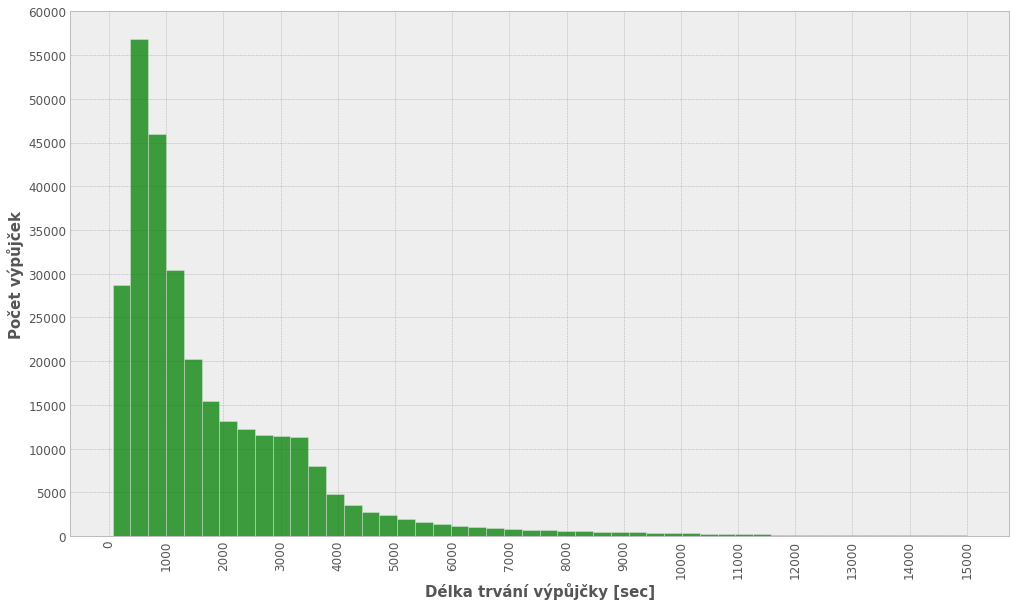

In [192]:
# Najděte odlehlé hodnoty, zobrazte histogram pomocí duration [sec]

# Z dat byly vyloučeny (duration) hodnoty mezi 15 000 až 1 373 043 sekund (1769 z celkových 320325 hodnot).
# Ve většině případů se jedná o výpůjčky kol, které zákazník zapomněl vrátit v zamýšleném čase a výrazně zkreslovaly histogram.
df_active_stations = df_active_stations[df_active_stations['duration'] <= 15000]

x = df_active_stations['duration'].to_numpy()

fig, ax = plt.subplots(figsize=(15, 9))

n, bins, patches = plt.hist(x, 48, density=False, facecolor='g', alpha=0.75)

plt.ylabel('Počet výpůjček', fontsize = 15, weight='bold')
plt.xlabel('Délka trvání výpůjčky [sec]', fontsize = 15, weight='bold')

plt.grid(True)
plt.xticks(np.arange(0, 15001, step=1000), rotation=90, fontsize = 12)
plt.yticks(np.arange(0, 60001, step=5000), fontsize = 12)

plt.show()

# Z histogramu je patrné, že cca polovina všech výpůjček je na dobu kratší než 1300 sekund (přibližně 22 minut).
# Třetina výpůjček se pak pohybuje v rozmezí 1300 - 3500 sekund (22 - 58 minut)

# Zobrazte vývoj poptávky po půjčování kol v čase.

In [93]:
# Pro každé datum vybereme unikátní hodnotu a spočítáme kolikrát se dané datum nachází v df_active_stations
unique, counts = np.unique(df_active_stations.started_at.values, return_counts=True)
df_daily_demand = (pd.DataFrame(counts, unique).reset_index()
                                               .rename(columns={'index': 'date', 0: 'daily_demand'}))

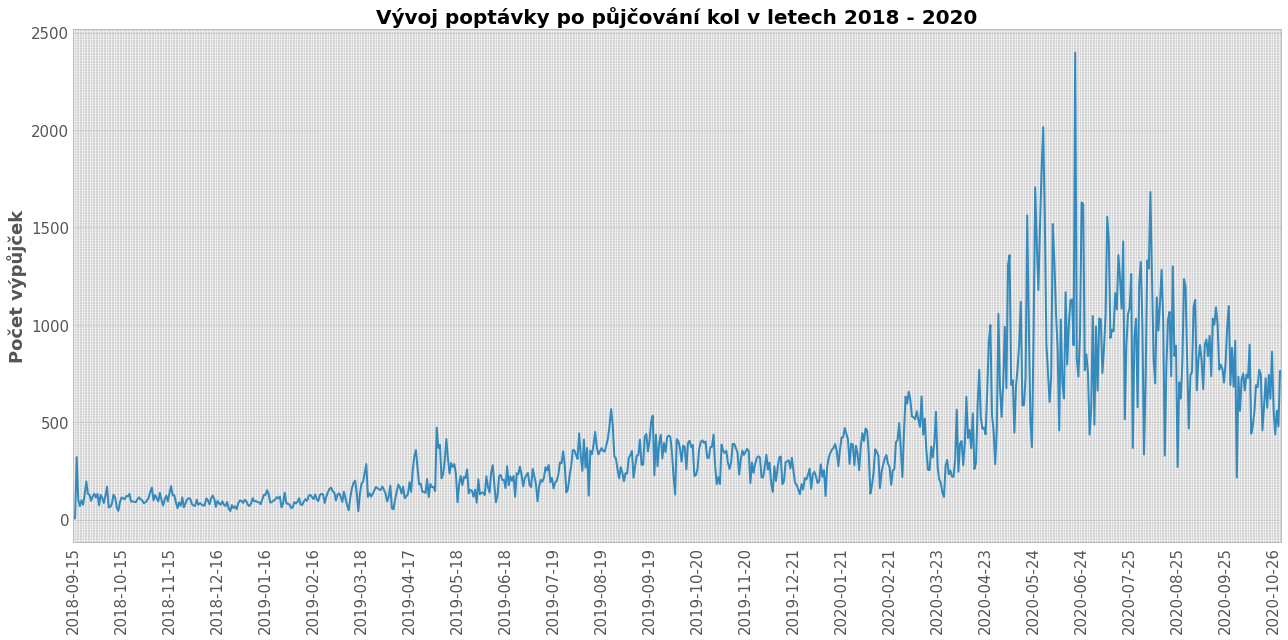

In [94]:
# Vývoj poptávky zobrazíme ve spojnicovém grafu.
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(18,9))

ax.plot(df_daily_demand['date'], df_daily_demand['daily_demand'])
ax.tick_params(axis='x', which='major', labelsize=15, rotation = 90)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.set_title('Vývoj poptávky po půjčování kol v letech 2018 - 2020', fontsize=20, fontweight='bold')
ax.set_ylabel('Počet výpůjček', fontsize=18, fontweight='bold')

# Na ose x se zobrazí každý 30tý den.
for i, t in enumerate(ax.get_xticklabels()):
    if (i % 30) != 0:
        t.set_visible(False)  
        
plt.xlim(-0.5,len(df_daily_demand)-.5)
plt.tight_layout()
plt.show()

# Z grafu lze vyčíst, že největší poptávka po kolech byla v roce 2020 zejména v letních měsících. 
# Lze se rovněž domnívat, že zvýšená poptávka v roce 2020 byla způsobena obavami lidí ze šíření koronaviru v MHD.

# Zjistěte vliv počasí na poptávku po kolech

In [85]:
# temp [°c], feels [°c], wind [km/h], gust [km/h], rain [mm], humidity [%], cloud [%], pressure [mb]
#df_weather = pd.read_csv('https://raw.githubusercontent.com/MichalLeh/Edinburgh-bikes-project/main/edinburgh_weather.csv')
df_weather.head(5)

,time,temp,feels,wind,gust,rain,humidity,cloud,pressure,vis,date
0,00:00,11 °c,11 °c,9 km/h from S,19 km/h,0.0 mm,79%,13%,1020 mb,Excellent,2018-09-01
1,03:00,13 °c,12 °c,11 km/h from SSW,19 km/h,0.0 mm,76%,96%,1020 mb,Excellent,2018-09-01
2,06:00,14 °c,13 °c,11 km/h from SSW,19 km/h,0.0 mm,84%,100%,1020 mb,Excellent,2018-09-01
3,09:00,14 °c,13 °c,14 km/h from SSW,23 km/h,0.1 mm,88%,78%,1021 mb,Excellent,2018-09-01
4,12:00,16 °c,16 °c,15 km/h from SSW,22 km/h,0.0 mm,87%,87%,1021 mb,Excellent,2018-09-01


In [86]:
# Z dataframu odstraníme jednotky [°c],[km/h],[mm],[%],[mb].
df_weather = (df_weather[['time', 'date', 'temp', 'feels', 'wind', 'gust', 'rain', 'humidity', 'cloud', 'pressure']]
                           .replace(to_replace ='[^0-9\:\-\.]', value = '', regex = True))

In [87]:
# Hodnoty převedeme do numerického formátu (int, float).
cols = ['temp', 'feels', 'wind', 'gust', 'rain', 'humidity', 'cloud', 'pressure']

df_weather[cols] = df_weather[cols].apply(lambda x: pd.to_numeric(x, errors='coerce'))

In [88]:
# Spočítáme průmernou hodnotu pro všechny meteorologické jevy za každý den.
df_weather = df_weather.groupby('date')[['temp', 'feels', 'wind', 'gust', 'rain', 'humidity', 'cloud','pressure']].mean().reset_index()

In [89]:
# Spojíme dohromady dataframy df_weather a df_daily_demand prostřednictvím klíče 'date'.
df_demand_weather = pd.merge(df_weather, df_daily_demand, on=['date'])
df_demand_weather.head(5)

,date,temp,feels,wind,gust,rain,humidity,cloud,pressure,daily_demand
0,2018-09-15,10.500,8.500,14.875,23.500,0.1250,83.875,58.125,1017.375,3
1,2018-09-16,12.875,10.625,26.500,43.125,0.1250,81.500,79.500,1008.875,8
2,2018-09-17,13.875,13.125,18.000,29.875,0.0250,83.000,66.125,1006.375,320
3,2018-09-18,14.125,13.500,16.875,28.500,0.2375,86.875,57.750,996.125,101
4,2018-09-19,11.750,8.625,34.750,55.625,0.3625,75.750,52.250,995.875,69


In [90]:
# Nakonec zjistíme vliv počasí na poptávku po kolech.
df_demand_weather.corr().loc[['daily_demand'], ['temp', 'feels', 'wind', 'gust', 'rain', 'humidity', 'cloud', 'pressure']]

# Největší vliv na poptávku má pocitová teplota (feels) a teplota (temp). Ostatní meteorologické jevy na výpůjčky vliv nemají.

,temp,feels,wind,gust,rain,humidity,cloud,pressure
daily_demand,0.430555,0.443116,-0.201238,-0.248958,-0.054465,-0.206595,-0.043994,0.107691


# Půjčují si lidé kola více o víkendu než během pracovního týdne?

In [95]:
# Převedeme datum 'date' na den v týdnu
df_demand_weather['date'] = pd.to_datetime(df_demand_weather['date'])
df_demand_weather['day_name'] = df_demand_weather['date'].dt.day_name()
df_demand_weather.head(5)

,date,temp,feels,wind,gust,rain,humidity,cloud,pressure,daily_demand,day_name
0,2018-09-15,10.500,8.500,14.875,23.500,0.1250,83.875,58.125,1017.375,3,Saturday
1,2018-09-16,12.875,10.625,26.500,43.125,0.1250,81.500,79.500,1008.875,8,Sunday
2,2018-09-17,13.875,13.125,18.000,29.875,0.0250,83.000,66.125,1006.375,320,Monday
3,2018-09-18,14.125,13.500,16.875,28.500,0.2375,86.875,57.750,996.125,101,Tuesday
4,2018-09-19,11.750,8.625,34.750,55.625,0.3625,75.750,52.250,995.875,69,Wednesday


In [96]:
# Spočítáme poptávku po kolech 'daily_demand' pro každý den v týdnu
df_favourite_days = (df_demand_weather.groupby(by=["day_name"])["daily_demand"]
               .sum()
               .to_frame()
               .sort_values(by='daily_demand')
               .reset_index()
              )

In [97]:
# Nejrušnějšími dny u Just Eat Cycles jsou sobota a neděle. O víkendu si tedy lidé půjčují kola více než ve dnech pracovního týdne.
df_favourite_days

,day_name,daily_demand
0,Monday,38855
1,Tuesday,39302
2,Wednesday,41249
3,Friday,42272
4,Thursday,43000
5,Sunday,43569
6,Saturday,47400
